# Zillow and Building Footprint Data, Merge

The following notebook contains code to combine Zillow housing data (which contains coordinate points associated with housing information, such as residence type) with MS Building Footprint data.

## Load in both data sets, cropping to LA

In [1]:
# Load necessary libraries
import os 
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import box

import matplotlib.pyplot as plt

In [2]:
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

### Zillow Data

In [3]:
# read in the zillow geo data (takes about 10 minutes)
fp = os.path.join('data', 'final_zillow.gpkg')
zillow = gpd.read_file(fp)

In [4]:
# change CRS to standard
zillow = zillow.to_crs("EPSG:4326")

# take a look at geodf
zillow.head()

,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,geometry
0,Multi,2003.0,1.0,None,None,I,224.0,491943.0,living,1003.0,3,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
1,Multi,2003.0,1.0,None,None,None,224.0,240117.0,living,936.0,4,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
2,Multi,2003.0,1.0,None,None,I,224.0,261770.0,living,997.0,5,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
3,Multi,2003.0,1.0,None,None,None,224.0,223337.0,living,1002.0,6,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
4,Multi,2003.0,1.0,None,None,None,224.0,241347.0,living,1003.0,7,06001403302,468,PGE/SCE,RR106,POINT (-122.26798 37.79406)


In [5]:
# create LA bbox
la_bbox = box(minx=-118.240125, miny=33.832560, maxx=-118.119275, maxy=33.907389)
la_bbox = gpd.GeoDataFrame(geometry=[la_bbox], crs=zillow.crs)

In [7]:
# clip zillow data to LA
zillow_la = gpd.clip(zillow, la_bbox)

# and check
zillow_la.head()

,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,geometry
2224925,Single,NaN,2.0,elec,None,None,1.0,76051.0,living,1188.0,3426071,06037571102,1134,PGE/SCE,RR101,POINT (-118.11959 33.83261)
2224926,Single,NaN,3.0,elec,None,O,1.0,378880.0,living,1430.0,3426072,06037571102,1134,PGE/SCE,RR101,POINT (-118.11941 33.83261)
2224924,Single,NaN,2.0,elec,None,O,1.0,487639.0,living,936.0,3426070,06037571102,1134,PGE/SCE,RR101,POINT (-118.11977 33.83261)
2225118,Single,NaN,2.0,elec,None,O,1.0,339905.0,living,1360.0,3426264,06037571102,1134,PGE/SCE,RR101,POINT (-118.12125 33.83262)
2225117,Single,NaN,2.0,elec,None,O,1.0,79819.0,living,1048.0,3426263,06037571102,1134,PGE/SCE,RR101,POINT (-118.12143 33.83262)


### Building Footprint Data

In [8]:
## this step may take a few seconds ##

# specify tile download url; this url is for area containing Santa Barbara, CA
url = 'https://data.source.coop/tge-labs/globalbuildingatlas-lod1/w120_n35_w115_n30.parquet'

# read the parquet file into a DataFrame
building_pqt = pd.read_parquet(url)

In [9]:
# extract limit information from `bbox` column using shapely
building_pqt["geometry"] = building_pqt["bbox"].apply(
    lambda b: box(b["xmin"], b["ymin"], b["xmax"], b["ymax"])
)

In [10]:
# convert dataframe to a geopandas object
building = gpd.GeoDataFrame(building_pqt, geometry="geometry", crs="EPSG:4326")

# confirm transformation worked and we have a geodataframe
building.head()

,source,id,height,var,region,bbox,geometry
0,google,85462X6M+6P29,0.593977,0.266378,MEX,"{'xmin': -115.01574894346501, 'ymin': 32.01048...","POLYGON ((-115.01570 32.01049, -115.01570 32.0..."
1,google,85462XJC+97CF,1.242497,0.375091,MEX,"{'xmin': -115.02951566605297, 'ymin': 32.03090...","POLYGON ((-115.02921 32.03090, -115.02921 32.0..."
2,google,85462XJC+93WR,3.569647,0.333383,MEX,"{'xmin': -115.029850167836, 'ymin': 32.0309691...","POLYGON ((-115.02977 32.03097, -115.02977 32.0..."
3,google,85462XJC+C3MX,3.547499,0.278828,MEX,"{'xmin': -115.029862555864, 'ymin': 32.0310179...","POLYGON ((-115.02977 32.03102, -115.02977 32.0..."
4,google,85462XJC+G248,1.096296,0.098254,MEX,"{'xmin': -115.03003018059, 'ymin': 32.03120930...","POLYGON ((-115.02980 32.03121, -115.02980 32.0..."


In [11]:
# clip data frame to LA using same bbox as before
building_la = gpd.clip(building, la_bbox)

## Pre-Join Checks

In [12]:
# same CRS
assert building_la.crs == zillow_la.crs

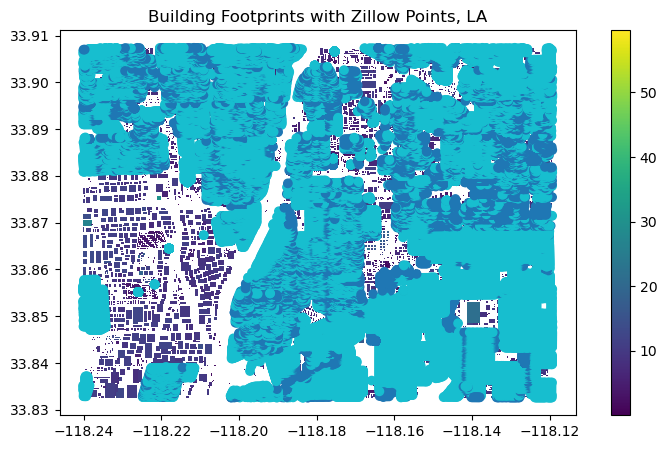

In [13]:
# preliminary plot

# initialize plot
fig, ax = plt.subplots(figsize=(9,5), nrows = 1, ncols = 1)

# plot building polygons
building_la.plot(ax = ax,
        column = 'height',
        legend = True)

# plot zillow points
zillow_la.plot(ax = ax,
               column = 'type')

plt.title("Building Footprints with Zillow Points, LA")
plt.show()

## Join Footprint Data onto Zillow

The spatial join will be done in this order because:
- the Zillow data corresponds only to residential buildings
- whereas the building footprints correspond to *all* buildings in LA, regardless of purpose
- we are only interested in residential units

The output of the spatial join should be a geodataframe that contains building polygons with zillow variables (like building type) associated with them.

In [15]:
zillow_building_la = gpd.sjoin(
    zillow_la,
    building_la,
    how="left",          # Keep all points, even those outside any polygon
    predicate="within"   # Join points that are within a polygon
)

zillow_building_la.head()

,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,...,area,code,geometry,index_right,source,id,height,var,region,bbox
2224925,Single,NaN,2.0,elec,None,None,1.0,76051.0,living,1188.0,...,PGE/SCE,RR101,POINT (-118.11959 33.83261),4397482.0,ms,UnitedStates_023013200_780006,4.388049,0.820917,USA,"{'xmin': -118.1196934449342, 'ymin': 33.832580..."
2224926,Single,NaN,3.0,elec,None,O,1.0,378880.0,living,1430.0,...,PGE/SCE,RR101,POINT (-118.11941 33.83261),4397480.0,ms,UnitedStates_023013200_265095,3.718395,0.846512,USA,"{'xmin': -118.11951281332972, 'ymin': 33.83256..."
2224924,Single,NaN,2.0,elec,None,O,1.0,487639.0,living,936.0,...,PGE/SCE,RR101,POINT (-118.11977 33.83261),4397481.0,ms,UnitedStates_023013200_147369,3.964420,0.159096,USA,"{'xmin': -118.11985677143053, 'ymin': 33.83260..."
2225118,Single,NaN,2.0,elec,None,O,1.0,339905.0,living,1360.0,...,PGE/SCE,RR101,POINT (-118.12125 33.83262),4397489.0,ms,UnitedStates_023013200_456106,4.020845,0.486160,USA,"{'xmin': -118.12133986659711, 'ymin': 33.83257..."
2225117,Single,NaN,2.0,elec,None,O,1.0,79819.0,living,1048.0,...,PGE/SCE,RR101,POINT (-118.12143 33.83262),4397490.0,ms,UnitedStates_023013200_44065,3.958990,0.166637,USA,"{'xmin': -118.12154292644588, 'ymin': 33.83258..."


<Axes: >

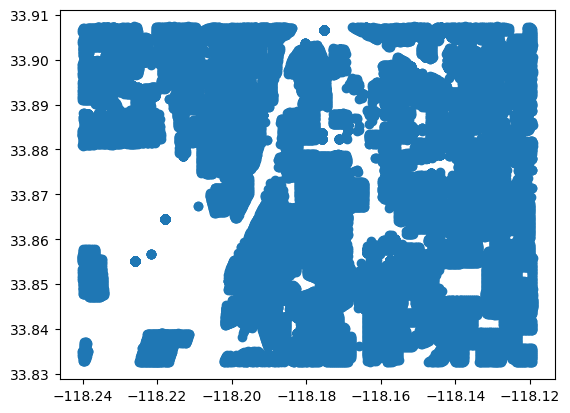

In [16]:
zillow_building_la.plot()

In [19]:
zillow_building_la = zillow_building_la.drop('index_right', axis=1)

zillow_building_la_2 = gpd.sjoin(
    zillow_building_la,
    building_la,
    how="right",
    predicate="intersects")

<Axes: >

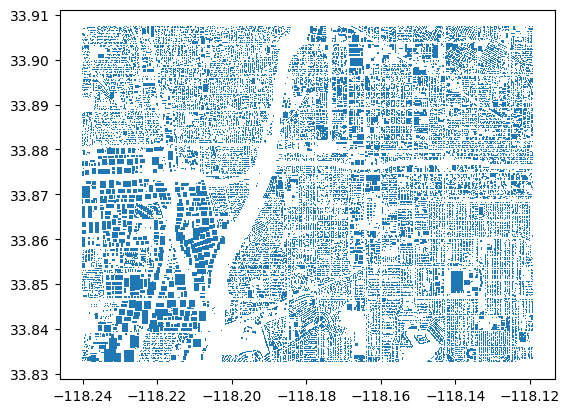

In [20]:
zillow_building_la_2.plot()